# Simple Normalized Coordinates

1D normalized coordinates originate from the normal form decomposition, where the transfer matrix that propagates phase space coordinates $(x, p)$ is decomposed as

$M = A \cdot R(\theta) \cdot A^{-1}$

And the matrix $A$ can be parameterized as

A = $\begin{pmatrix}\sqrt{\beta} & 0\\-\alpha/\sqrt{\beta} & 1/\sqrt{\beta}\end{pmatrix}$


In [1]:
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import A_mat_calc, twiss_calc, normalized_particle_coordinate, twiss_ellipse_points
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'

In [2]:
help(A_mat_calc)

Help on function A_mat_calc in module pmd_beamphysics.statistics:

A_mat_calc(beta, alpha, inverse=False)
    Returns the 1D normal form matrix from twiss parameters beta and alpha
    
        A =   sqrt(beta)         0 
             -alpha/sqrt(beta)   1/sqrt(beta) 
    
    If inverse, the inverse will be returned:
    
        A^-1 =  1/sqrt(beta)     0 
                alpha/sqrt(beta) sqrt(beta)     
    
    This corresponds to the linear normal form decomposition:
    
        M = A . Rot(theta) . A^-1
    
    with a clockwise rotation matrix:
    
        Rot(theta) =  cos(theta) sin(theta)
                     -sin(theta) cos(theta)
    
    In the Bmad manual, G_q (Bmad) = A (here) in the Linear Optics chapter.
    
    A^-1 can be used to form normalized coordinates: 
        x_bar, px_bar   = A^-1 . (x, px)



Make phase space circle. This will represent some normalized coordinates:

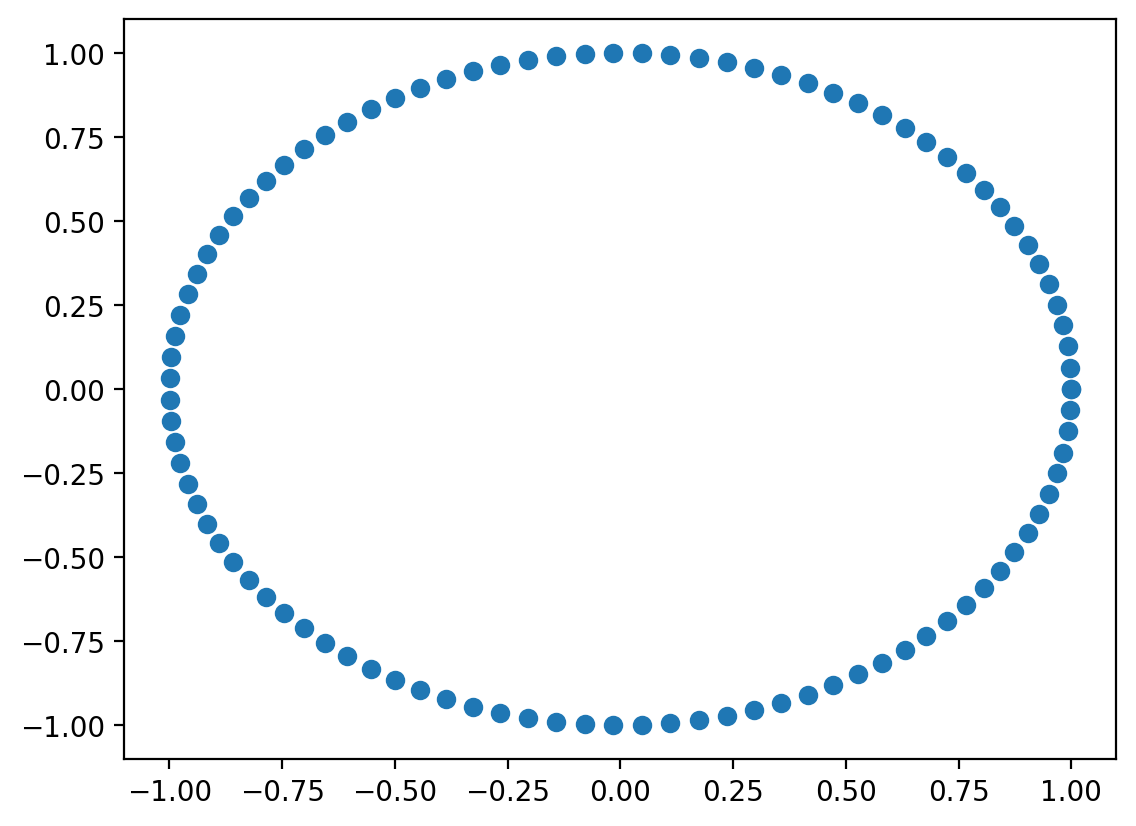

In [3]:
theta = np.linspace(0, np.pi*2, 100)
zvec0 = np.array([np.cos(theta), np.sin(theta)])
plt.scatter(*zvec0)

Make a 'beam' in 'lab coordinates':

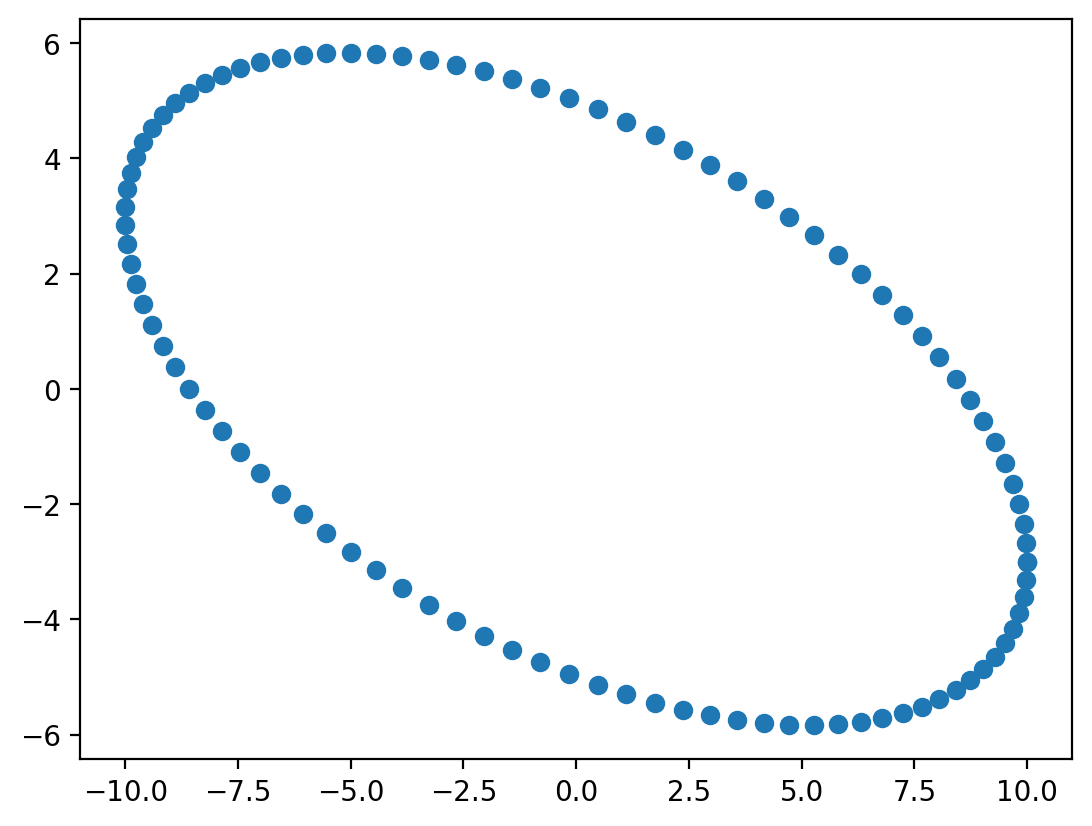

In [4]:
MYMAT = np.array([[10, 0],[-3, 5]])
zvec = np.matmul(MYMAT , zvec0)
plt.scatter(*zvec)

With a beam, $\alpha$ and $\beta$ can be determined from moments of the covariance matrix.

In [5]:
help(twiss_calc)

Help on function twiss_calc in module pmd_beamphysics.statistics:

twiss_calc(sigma_mat2)
    Calculate Twiss parameters from the 2D sigma matrix (covariance matrix):
    sigma_mat = <x,x>   <x, p>
                <p, x>  <p, p>
    
    This is a simple calculation. Makes no assumptions about units. 
    
    alpha = -<x, p>/emit
    beta  =  <x, x>/emit
    gamma =  <p, p>/emit
    emit = det(sigma_mat)



Calculate a sigma matrix, get the determinant:

In [6]:
sigma_mat2 = np.cov(*zvec)
np.linalg.det(sigma_mat2)

np.float64(637.5000000000003)

Get some twiss:

In [7]:
twiss = twiss_calc(sigma_mat2)
twiss

{'alpha': np.float64(0.6059702963017245),
 'beta': np.float64(2.0199009876724157),
 'gamma': np.float64(0.6768648603788545),
 'emit': np.float64(25.248762345905202)}

Analyzing matrices:

In [8]:
A = A_mat_calc(twiss['beta'], twiss['alpha'])
A_inv = A_mat_calc(twiss['beta'], twiss['alpha'], inverse=True)

A_inv turns this back into a circle:

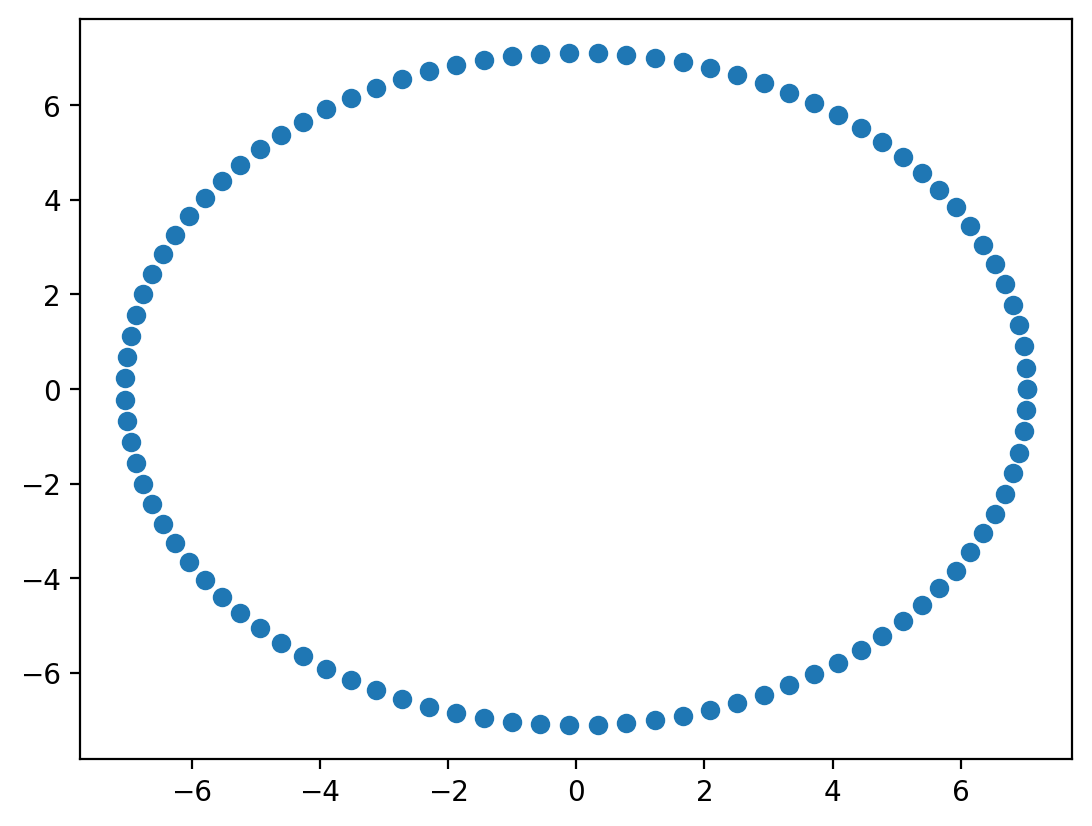

In [9]:
zvec2 = np.matmul(A_inv, zvec)
plt.scatter(*zvec2)

# Twiss parameters

Effective Twiss parameters can be calculated from the second order moments of the particles.

This does not change the phase space area.


In [10]:
twiss_calc(np.cov(*zvec2))

{'alpha': np.float64(1.4672219335410167e-16),
 'beta': np.float64(1.0),
 'gamma': np.float64(1.0000000000000002),
 'emit': np.float64(25.24876234590519)}

In [11]:

matplotlib.rcParams['figure.figsize'] = (13,8) # Reset plot

# x_bar, px_bar, Jx, etc.

These are essentially action-angle coordinates, calculated by using the an analyzing twiss dict

In [12]:
help(normalized_particle_coordinate)

Help on function normalized_particle_coordinate in module pmd_beamphysics.statistics:

normalized_particle_coordinate(particle_group, key, twiss=None, mass_normalize=True)
    Returns a single normalized coordinate array from a ParticleGroup
    
    Position or momentum is determined by the key. 
    If the key starts with 'p', it is a momentum, else it is a position,
    and the
    
    Intended use is for key to be one of:
        x, px, y py
        
    and the corresponding normalized coordinates are named with suffix _bar, i.e.:
        x_bar, px_bar, y_bar, py_bar
    
    If mass_normalize (default=True), the momentum will be divided by the mass, so that the units are sqrt(m).
    
    These are related to action-angle coordinates
        J: amplitude
        phi: phase
        
        x_bar =  sqrt(2 J) cos(phi)
        px_bar = sqrt(2 J) sin(phi)
        
    So therefore:
        J = (x_bar^2 + px_bar^2)/2
        phi = arctan(px_bar/x_bar)
    and:        
        <J> = 

Get some example particles, with a typical transverse phase space plot:

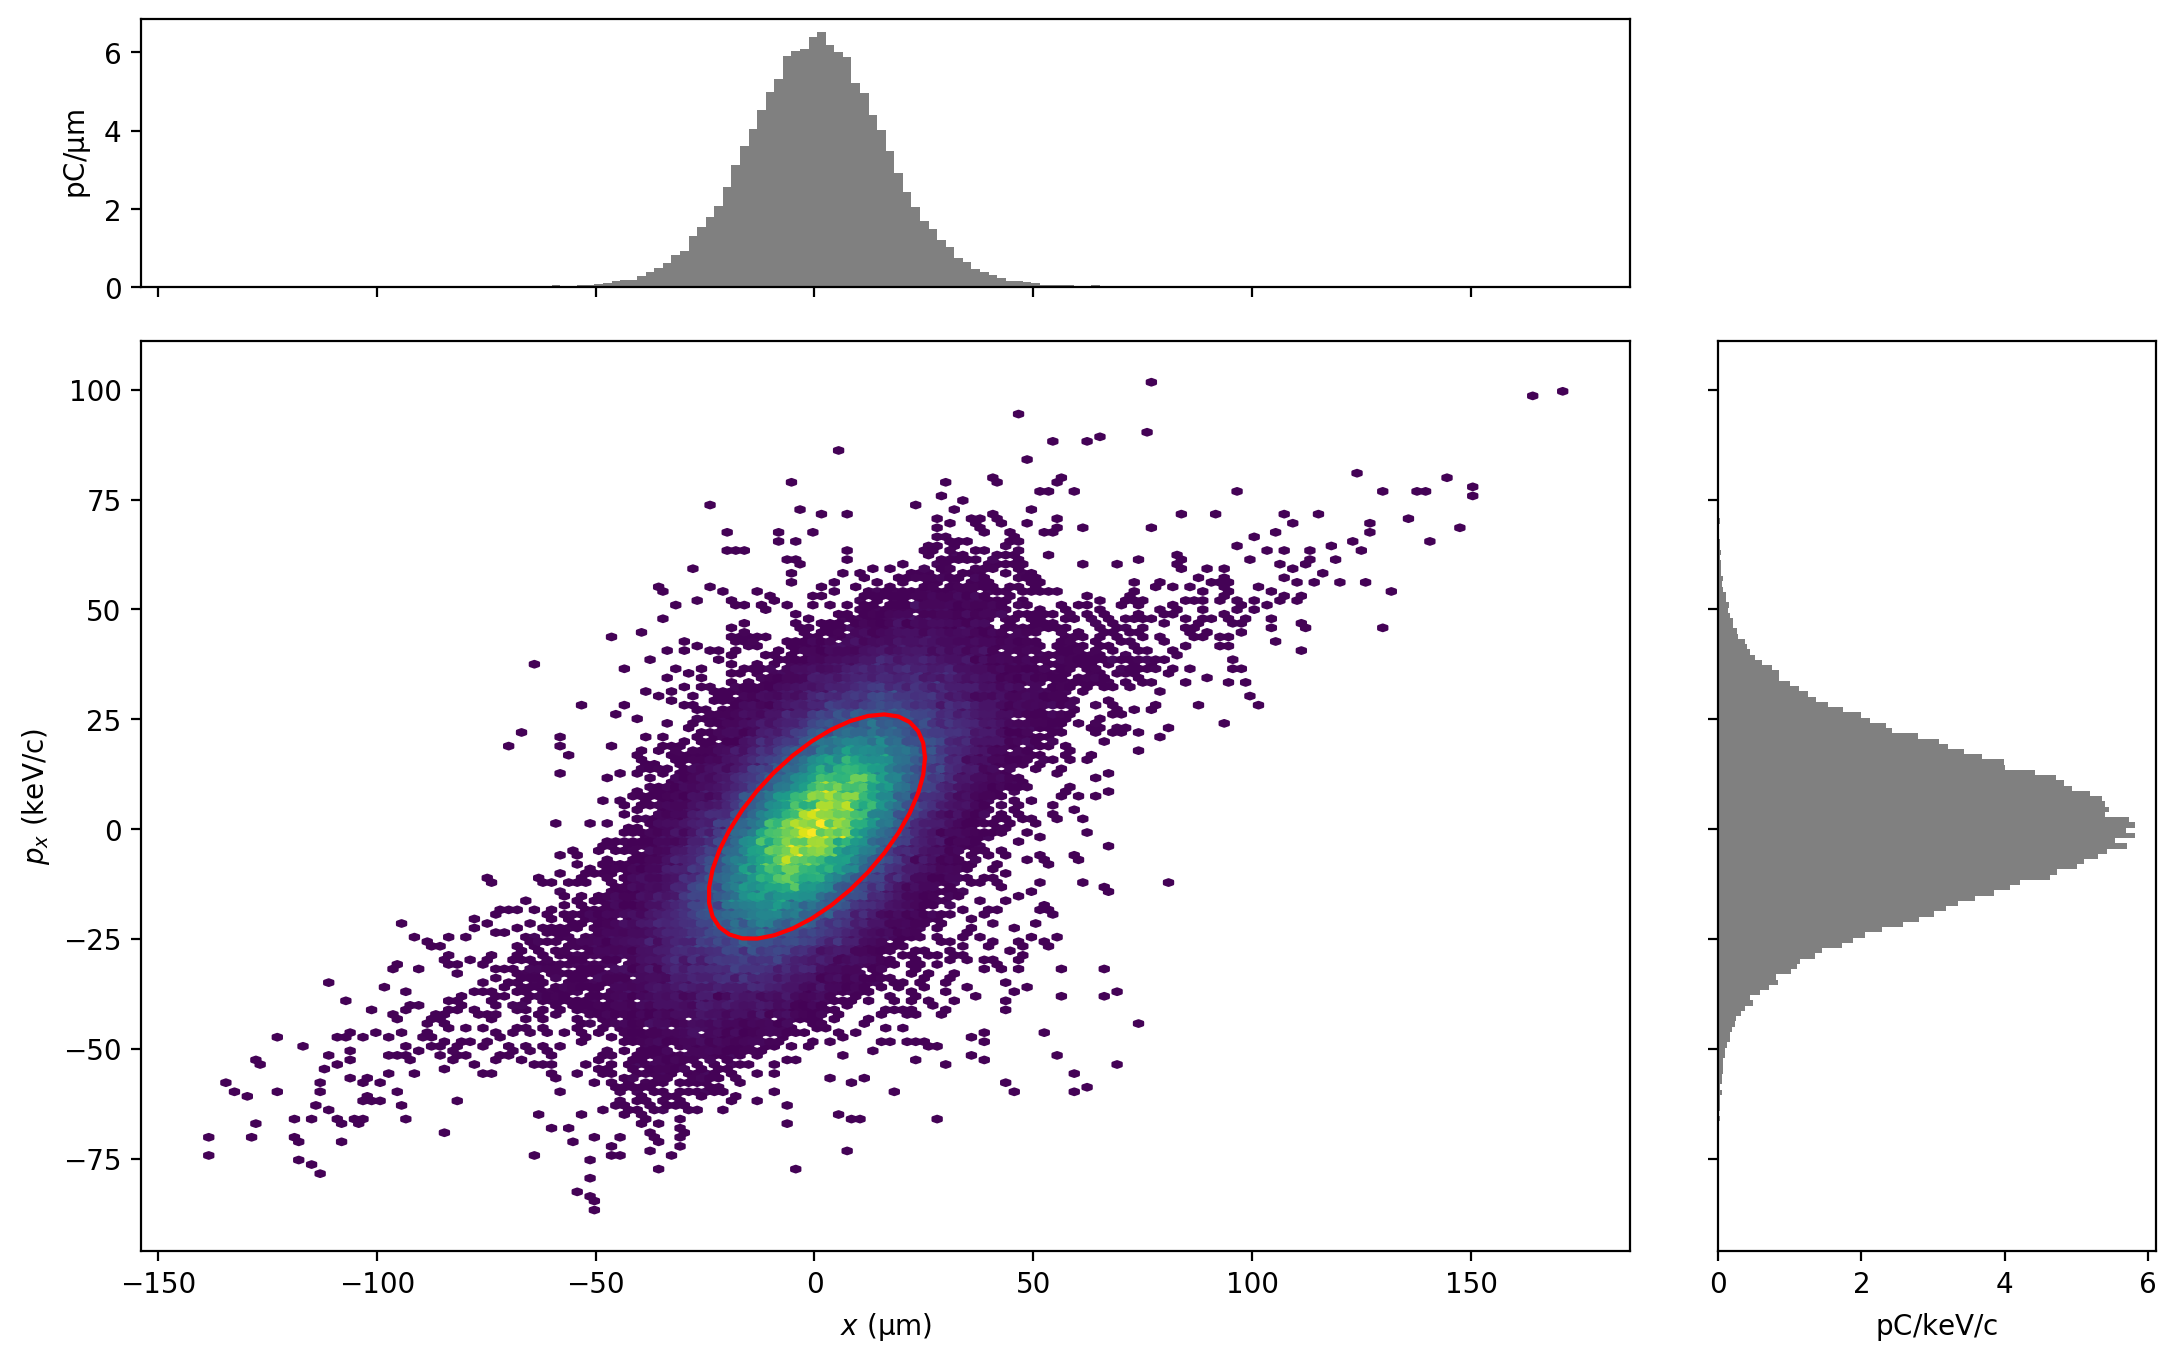

In [13]:
P = ParticleGroup('data/bmad_particles2.h5')
P.plot('x', 'px', ellipse=True)

If no twiss is given, then the analyzing matrix is computed from the beam itself:

In [14]:
normalized_particle_coordinate(P, 'x', twiss=None)

array([-4.83384095e-04,  9.99855846e-04,  7.35820860e-05, ...,
       -7.48265408e-05,  4.77803205e-05, -4.18053319e-04])

This is equivelent:

In [15]:
normalized_particle_coordinate(P, 'x', twiss=twiss_calc(P.cov('x', 'px')), mass_normalize=False)/np.sqrt(P.mass)

array([-4.83384095e-04,  9.99855846e-04,  7.35820860e-05, ...,
       -7.48265408e-05,  4.77803205e-05, -4.18053319e-04])

And is given as a property:

In [16]:
P.x_bar

array([-4.83384095e-04,  9.99855846e-04,  7.35820860e-05, ...,
       -7.48265408e-05,  4.77803205e-05, -4.18053319e-04])

The amplitude is defined as:

In [17]:
(P.x_bar**2 + P.px_bar**2)/2

array([1.16831464e-07, 5.85751290e-07, 3.26876598e-07, ...,
       3.25916449e-07, 2.21097254e-07, 2.73364174e-07])

This is also given as a property:

In [18]:
P.Jx

array([1.16831464e-07, 5.85751290e-07, 3.26876598e-07, ...,
       3.25916449e-07, 2.21097254e-07, 2.73364174e-07])

 Note the mass normalization is the same:

In [19]:
P.Jx.mean(), P['mean_Jx'], P['norm_emit_x']

(np.float64(4.883790126887025e-07),
 np.float64(4.883790126887027e-07),
 np.float64(4.881047612307434e-07))

This is now nice and roundish:

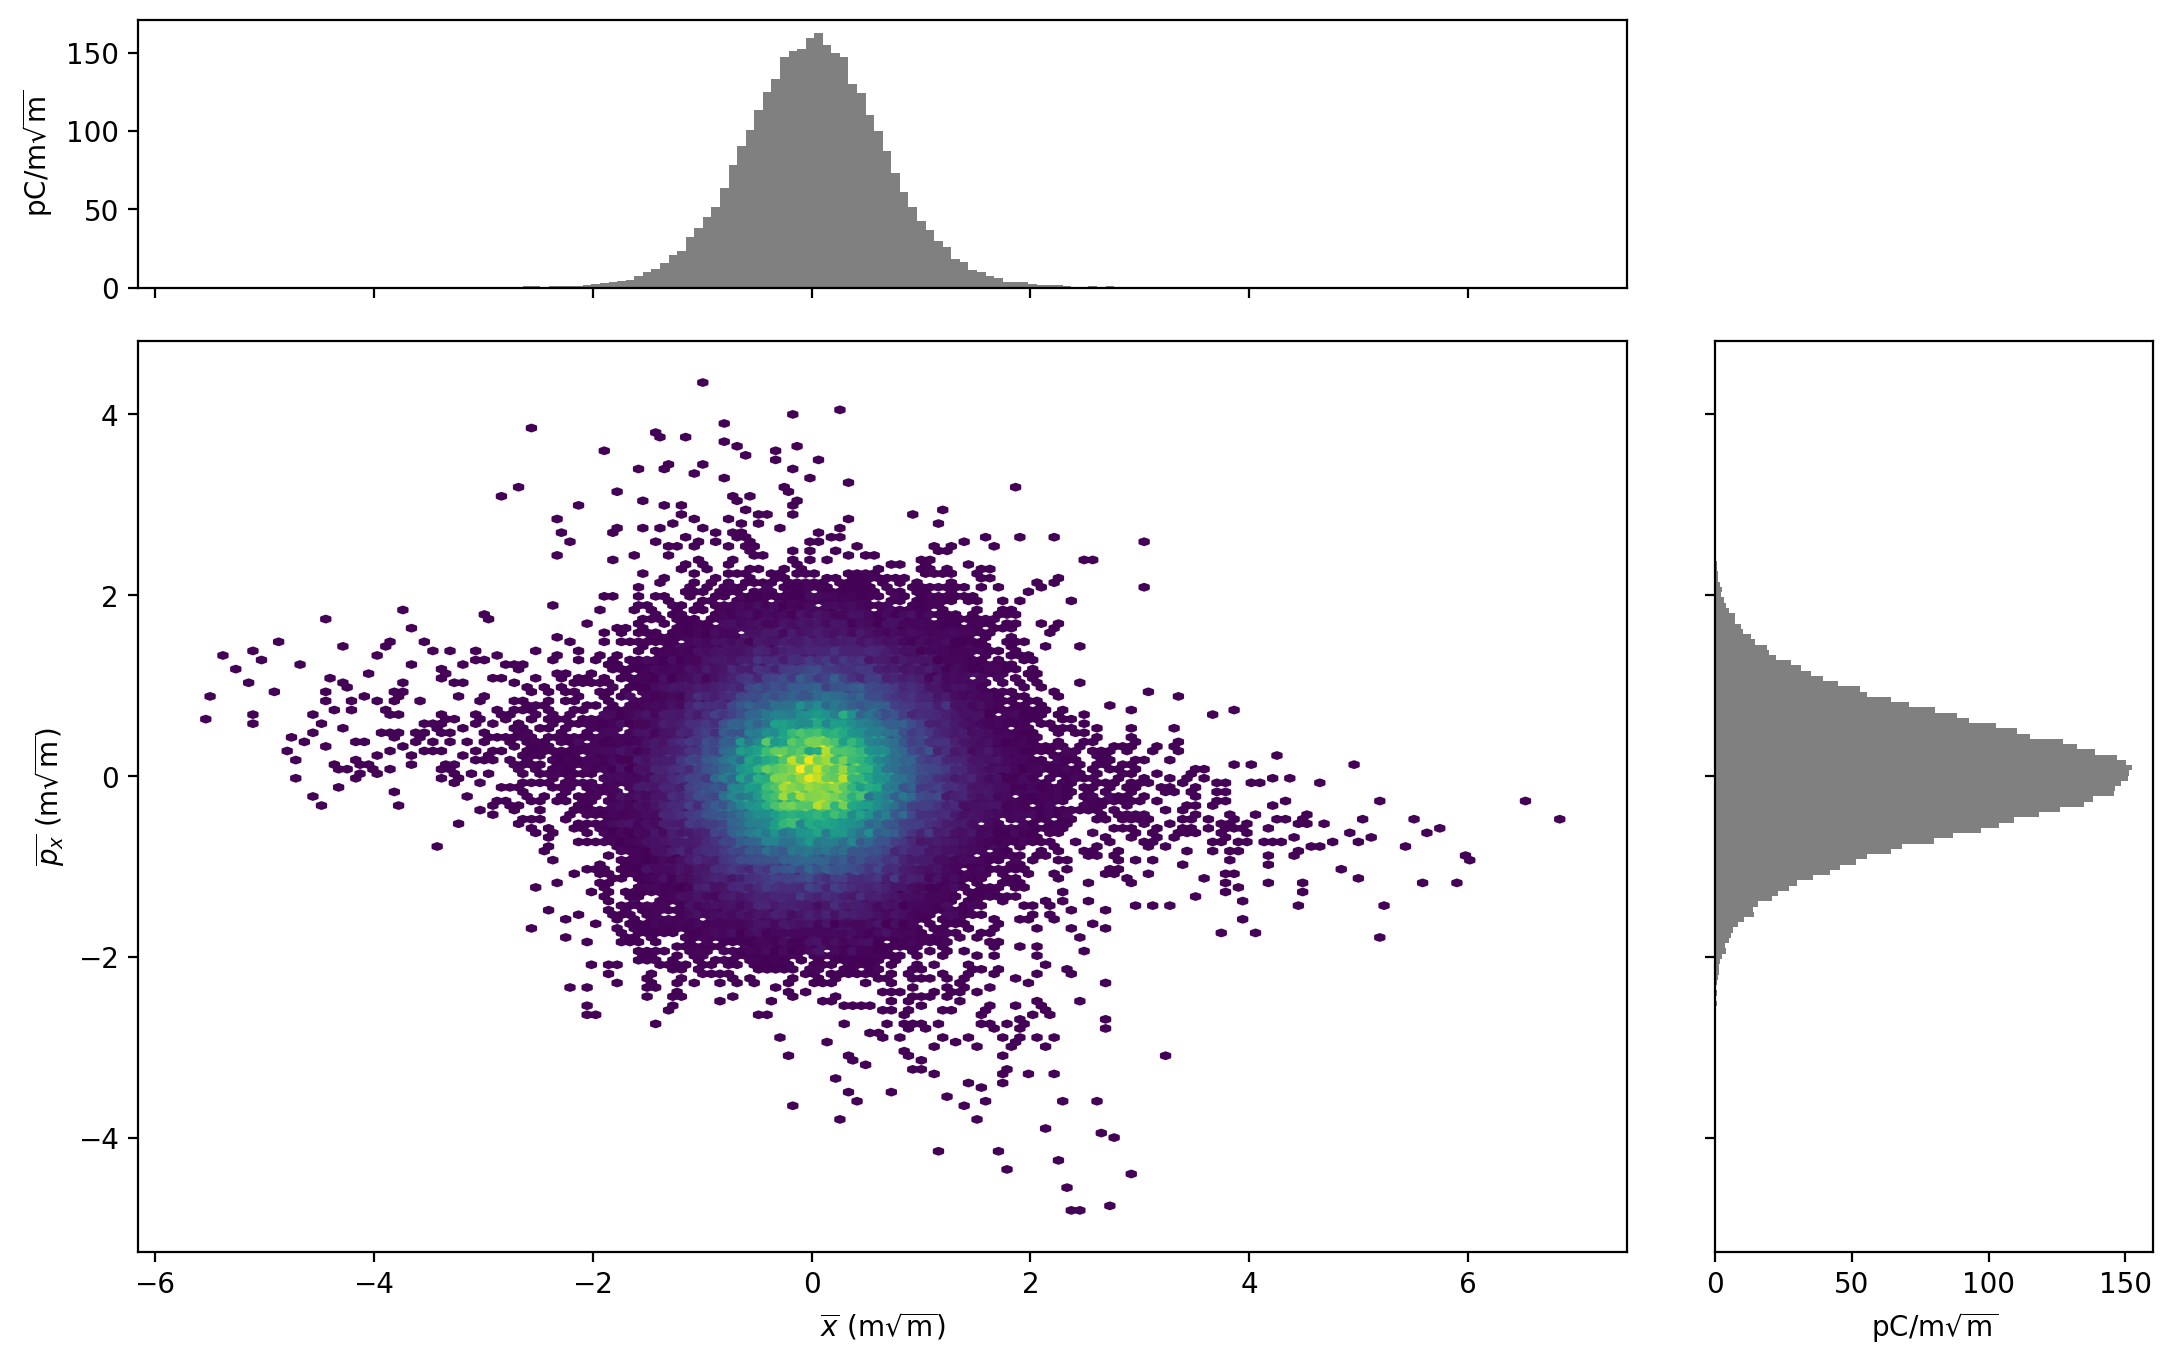

In [20]:
P.plot('x_bar', 'px_bar')

Jy also works. This gives some sense of where the emittance is larger.

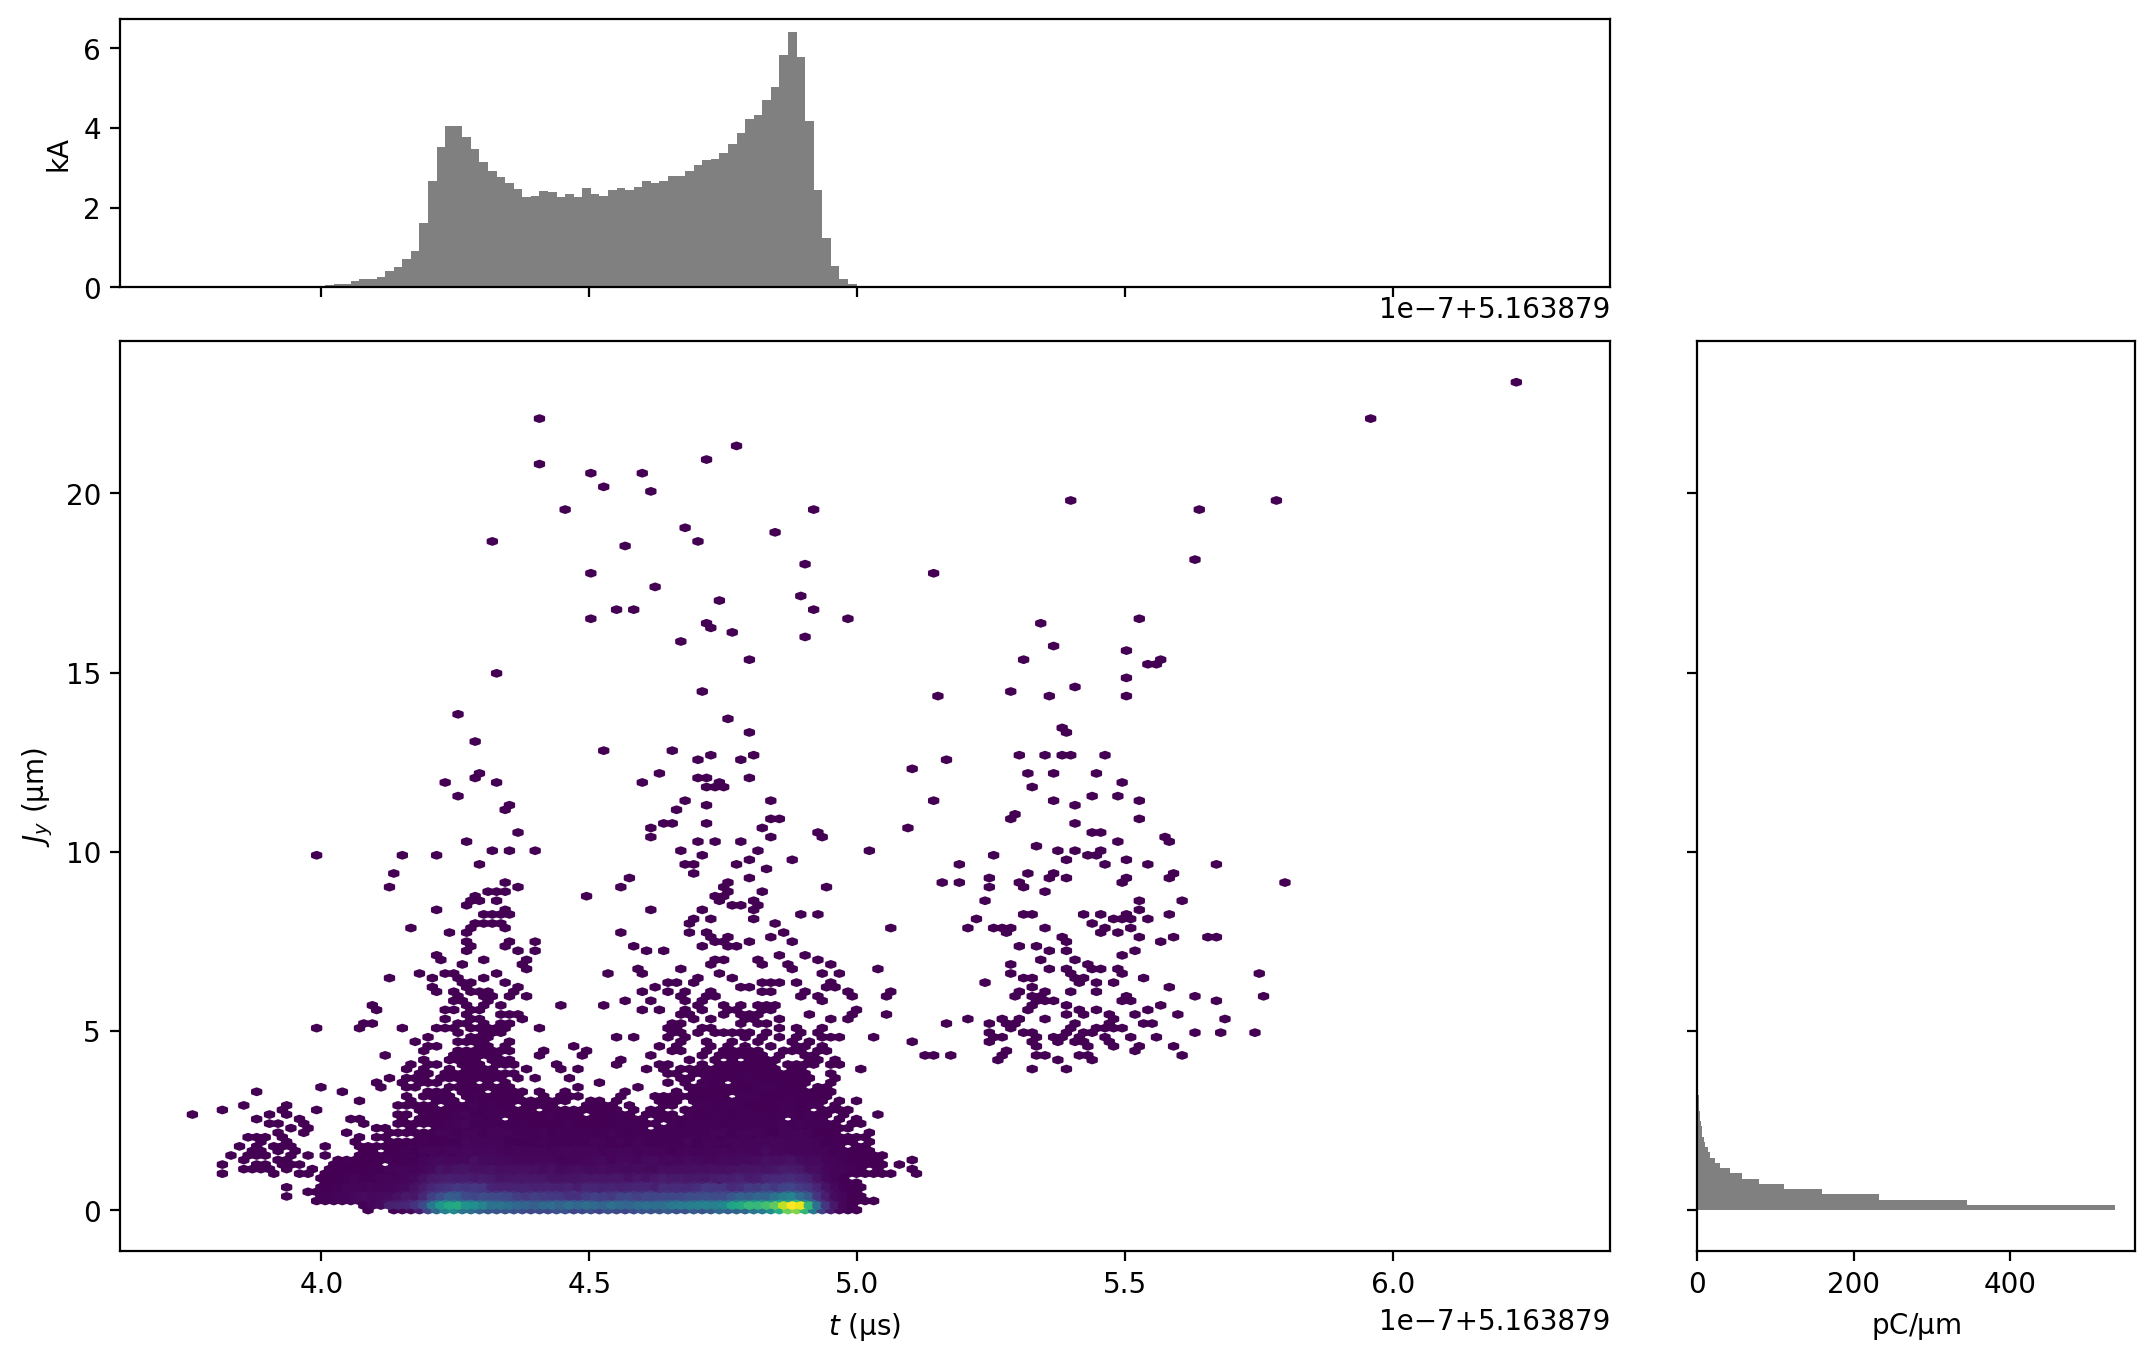

In [21]:
P.plot('t', 'Jy')

Sort by Jx:

In [22]:
P = P[np.argsort(P.Jx)]

Now particles are ordered:

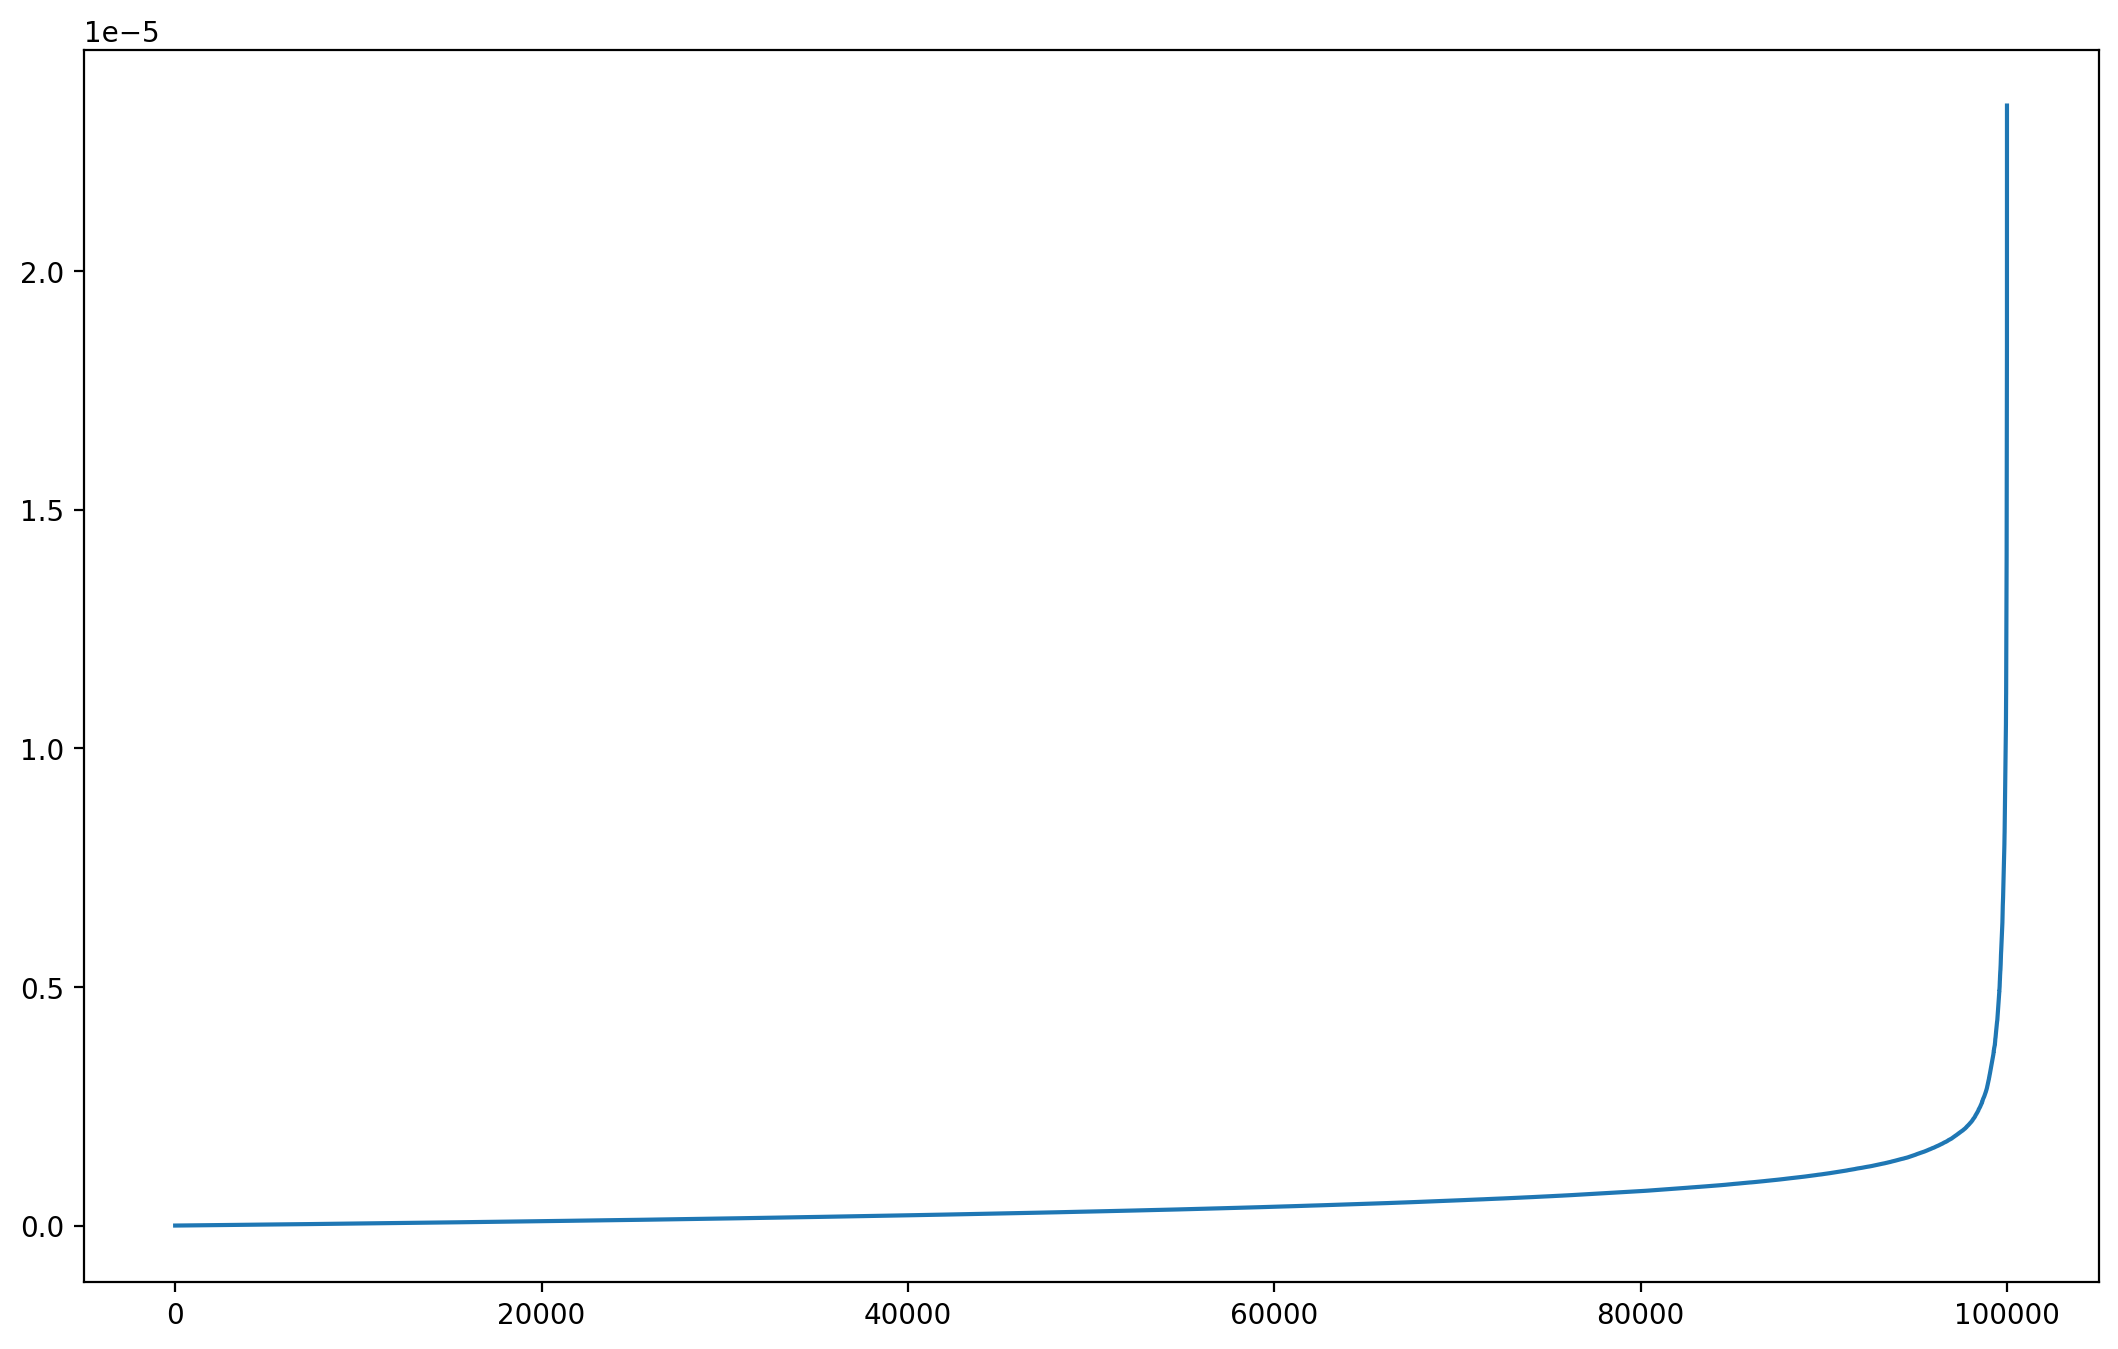

In [23]:
plt.plot(P.Jx)

This can be used to calculate the 95% emittance:

In [24]:
P[0:int(0.95*len(P))]['norm_emit_x']

np.float64(3.7399940158442355e-07)

# Plot ellipse

For convenience this function is available

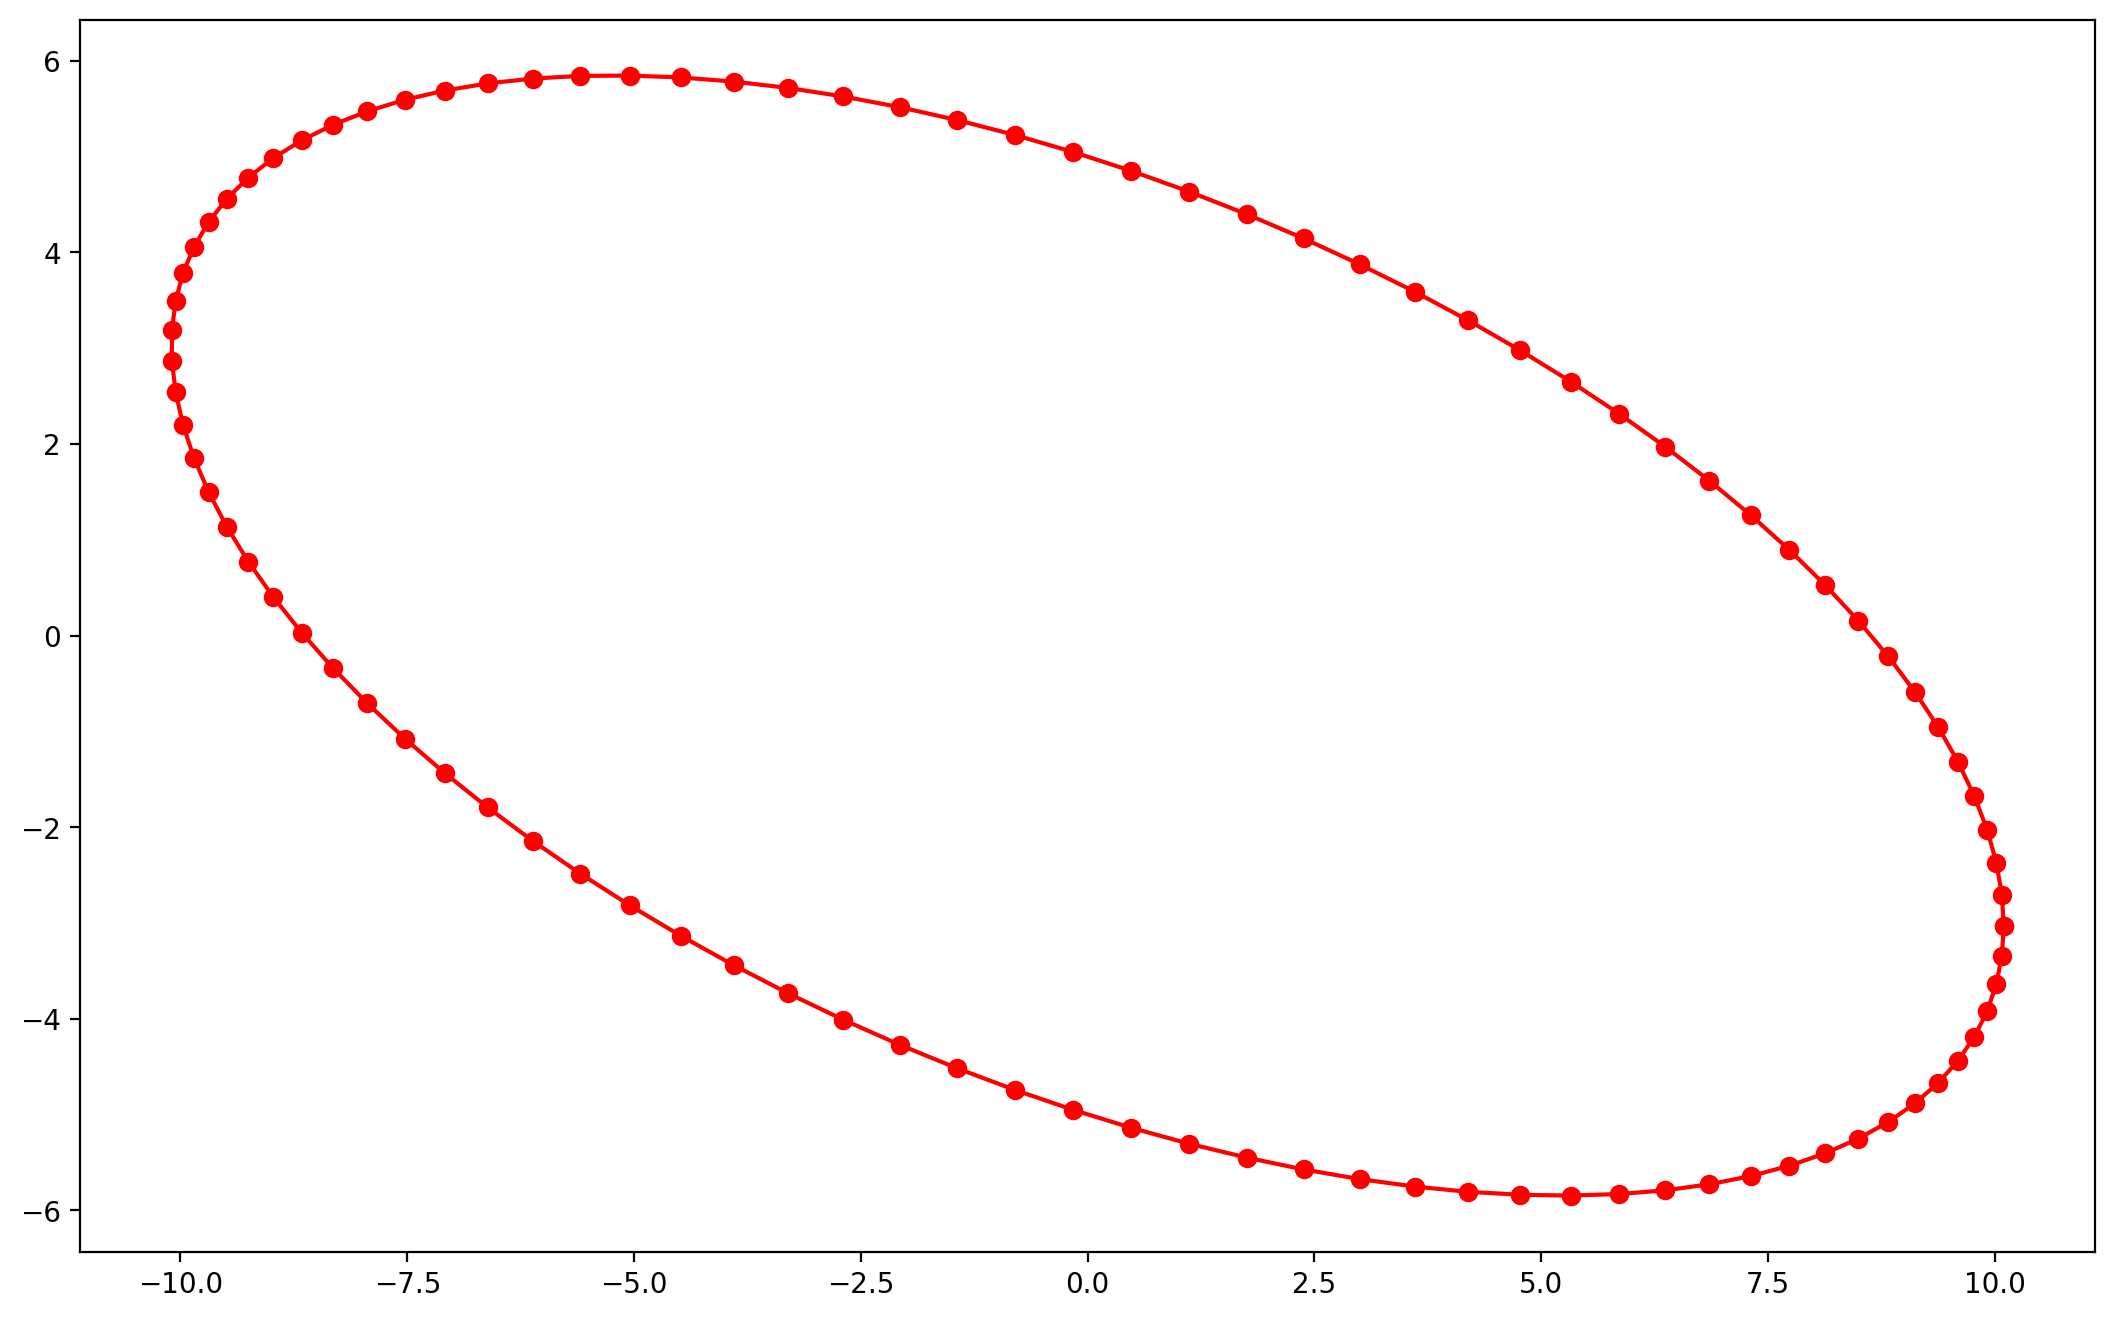

In [25]:
x, p = twiss_ellipse_points(sigma_mat2, n_points=100)
plt.plot(x, p, color='red')
plt.scatter(x, p, color='red')

# Simple 'matching'

Often a beam needs to be 'matched' for tracking in some program.

This is a 'faked' tranformation that ultimately would need to be realized by a focusing system.

In [26]:
def twiss_match(x, p, beta0=1, alpha0=0, beta1=1, alpha1=0):
    """
    Simple Twiss matching. 
    
    Takes positions x and momenta p, and transforms them according to 
    initial Twiss parameters:
        beta0, alpha0 
    into final  Twiss parameters:
        beta1, alpha1
        
    This is simply the matrix ransformation:    
        xnew  = (   sqrt(beta1/beta0)                  0                 ) . ( x )
        pnew    (  (alpha0-alpha1)/sqrt(beta0*beta1)   sqrt(beta0/beta1) )   ( p ) 
        

    Returns new x, p
    
    """
    m11 = np.sqrt(beta1/beta0)
    m21 = (alpha0-alpha1)/np.sqrt(beta0*beta1)
    
    xnew = x * m11
    pnew = x * m21 + p / m11
    
    return xnew, pnew

Get some Twiss:

In [27]:
T0 = twiss_calc(P.cov('x', 'xp'))
T0

{'alpha': np.float64(-0.7756418199427733),
 'beta': np.float64(9.761411505651415),
 'gamma': np.float64(0.16407670467707158),
 'emit': np.float64(3.127519925999214e-11)}

 Make a copy and maniplulate:

In [28]:
P2 = P.copy()
P2.x, P2.px = twiss_match(P.x, P.px/P['mean_p'], beta0=T0['beta'], alpha0=T0['alpha'], beta1=9, alpha1=-2)
P2.px *= P['mean_p']

In [29]:
twiss_calc(P2.cov('x', 'xp'))

{'alpha': np.float64(-1.9995993293102663),
 'beta': np.float64(9.00102737307016),
 'gamma': np.float64(0.5553141070021174),
 'emit': np.float64(3.12716295233219e-11)}

This is a dedicated routine:

In [30]:
def matched_particles(particle_group, beta=None, alpha=None, plane='x', p0c=None, inplace=False):
    """
    Perfoms simple Twiss 'matching' by applying a linear transformation to
        x, px if plane == 'x', or x, py if plane == 'y'
    
    Returns a new ParticleGroup
    
    If inplace, a copy will not be made, and changes will be done in place. 
    
    """
    
    assert plane in ('x', 'y'), f'Invalid plane: {plane}'
    
    if inplace:
        P = particle_group
    else:
        P = particle_group.copy()
    
    if not p0c:
        p0c = P['mean_p']
    

    # Use Bmad-style coordinates.
    # Get plane. 
    if plane == 'x':
        x = P.x
        p = P.px/p0c
    else:
        x = P.y
        p = P.py/p0c
        
    # Get current Twiss
    tx = twiss_calc(np.cov(x, p, aweights=P.weight))
    
    # If not specified, just fill in the current value.
    if alpha is None:
        alpha = tx['alpha']
    if beta is None:
        beta = tx['beta']
    
    # New coordinates
    xnew, pnew = twiss_match(x, p, beta0=tx['beta'], alpha0=tx['alpha'], beta1=beta, alpha1=alpha)
    
    # Set
    if plane == 'x':
        P.x = xnew
        P.px = pnew*p0c
    else:
        P.y = xnew
        P.py = pnew*p0c
        
    return P
    
    
# Check    
P3 = matched_particles(P, beta=None, alpha=-4, plane='y')
P.twiss(plane='y'), P3.twiss(plane='y')

({'alpha_y': np.float64(0.9058122605337396),
  'beta_y': np.float64(14.683316714787708),
  'gamma_y': np.float64(0.12398396674913406),
  'emit_y': np.float64(3.214301173354259e-11),
  'eta_y': np.float64(-0.0001221701145704683),
  'etap_y': np.float64(-3.1414468851691344e-07),
  'norm_emit_y': np.float64(5.016420878150227e-07)},
 {'alpha_y': np.float64(-3.9999679865267384),
  'beta_y': np.float64(14.683316715010363),
  'gamma_y': np.float64(1.1577591237176261),
  'emit_y': np.float64(3.214301173290241e-11),
  'eta_y': np.float64(-0.00012217012301264445),
  'etap_y': np.float64(-4.113188244396527e-05),
  'norm_emit_y': np.float64(5.016420878133589e-07)})

These functions are in statistics:

In [31]:
from pmd_beamphysics.statistics import twiss_match, matched_particles